In [2]:
import torch 
import numpy as np
from ode_nn import *
from scipy.integrate import odeint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

# Read Data

In [6]:
# N = 10000, I0 = 10, R0 = 0, E0 = 0, beta = 0.8, gamma = 0.1, sigma = 0.2, num_steps = 60, step size = 1
SEIR = torch.load("/home/ec2-user/SageMaker/efs/Danielle/Ray/Data/SEIR_test_sample.pt")
# N = 10000, I0 = 10, R0 = 0, beta = 0.8, gamma = 0.1, num_steps = 60
SIR = torch.load("/home/ec2-user/SageMaker/efs/Danielle/Ray/Data/SIR_test_sample.pt")

# SIR: 
## Fully Connected NN

In [7]:
class FC(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FC, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, 3)
        )
        self.y0 = torch.nn.Parameter(torch.cuda.FloatTensor([[0]]))
    def forward(self, t):
        y_preds = []
        for i in range(len(t)):
            y_preds.append(self.model(t[i].reshape(1,1)))
        return torch.cat(y_preds, dim = 0)

In [8]:
model_fc = FC(input_dim = 1, hidden_dim = 32).cuda()
t = torch.from_numpy(np.linspace(0, 60//2, 61)).float().cuda()
y_exact = SIR.float().cuda()/10000
optimizer = torch.optim.Adam(model_fc.parameters(), 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.95)
num_epochs = 2000
loss_fun = torch.nn.MSELoss()
tqdm_epochs = tqdm(range(num_epochs))
min_loss = 10

for e in tqdm_epochs:
    #forward pass
    y_approx = model_fc(t.to(device)[:30])
    loss = loss_fun(y_approx, y_exact[:30].to(device))
    if loss.item() < min_loss:
        best_model_fc = model_fc
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    tqdm_epochs.set_postfix({'loss': torch.sum(loss).item()})

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


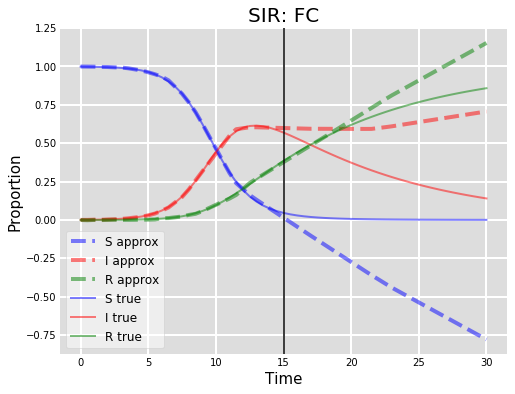

In [9]:
x = np.linspace(0, 60//2, 61)
fig=plt.figure(figsize=(8, 6))#fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
y_pred = best_model_fc(t.to(device))
ax.plot(x, y_pred[:,0].cpu().data.numpy(), 'b', alpha=0.5, lw=4, linestyle = "--", label='S approx')
ax.plot(x, y_pred[:,1].cpu().data.numpy(), 'r', alpha=0.5, lw=4, linestyle = "--", label='I approx')
ax.plot(x, y_pred[:,2].cpu().data.numpy(), 'g', alpha=0.5, lw=4, linestyle = "--", label='R approx')

ax.plot(x, y_exact[:,0].cpu().data.numpy(), 'b', alpha=0.5, lw=2,  label='S true')
ax.plot(x, y_exact[:,1].cpu().data.numpy(), 'r', alpha=0.5, lw=2,  label='I true')
ax.plot(x, y_exact[:,2].cpu().data.numpy(), 'g', alpha=0.5, lw=2,  label='R true')
ax.axvline(15, color = "black")
ax.set_xlabel('Time', size = 15)
ax.set_ylabel('Proportion', size = 15)
#ax.set_ylim(-0.1,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(fontsize = 12, loc = 3)
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
# N = 10000, I0 = 10, R0 = 0, beta = 0.8, gamma = 0.1, num_steps = 60
plt.title("SIR: FC" , fontsize = 20)#+ r"$N=10000, I_0 = 10, \beta = 0.8, \gamma = 0.1$"
#plt.savefig("SIR_FC.png", dpi = 400 , bbox_inches = "tight")    
plt.show()

In [8]:
print("first 30 steps:", np.round(torch.sqrt(torch.mean(((y_exact - y_pred)**2)[:30])).cpu().data.numpy(), 3))
print("last 30 steps:", np.round(torch.sqrt(torch.mean(((y_exact - y_pred)**2)[30:])).cpu().data.numpy(), 3))

first 30 steps: 0.003
last 30 steps: 0.334


# SIR: 
## Learn $\beta, \gamma, y_0$ + ODE solver
\begin{align*}
&\frac{dS}{dt} = -\frac{\beta SI}{N} \\
&\frac{dI}{dt} = \frac{\beta SI}{N} - \gamma I \\
&\frac{dR}{dt} = \gamma I \\
& N = I + R + S
\end{align*}

In [ ]:
class Neural_ODE(nn.Module):
    def __init__(self, solver = "Euler"):
        super(Neural_ODE, self).__init__()
        self.initial = torch.nn.Parameter(torch.rand(3)/10)#1torch.tensor([0.999,   0.001,    0.]).cuda()#
        self.beta = torch.nn.Parameter(torch.rand(1)/10)#torch.tensor(0.8).cuda()#
        self.gamma = torch.nn.Parameter(torch.rand(1)/10)#torch.tensor(0.1).cuda()#
        self.step = torch.tensor(0.5).cuda()
        self.solver = solver
        
    def Euler(self, t):
        S_pred = [self.initial[0].reshape(-1,1)]
        I_pred = [self.initial[1].reshape(-1,1)]
        R_pred = [self.initial[2].reshape(-1,1)]
        for n in range(len(t)-1):
            S_pred.append((S_pred[n] - self.beta*S_pred[n]*I_pred[n]*self.step).reshape(-1,1))
            I_pred.append((I_pred[n] + (self.beta*S_pred[n]*I_pred[n] - self.gamma*I_pred[n])*self.step).reshape(-1,1))
            R_pred.append((R_pred[n] + self.gamma*I_pred[n]*self.step).reshape(-1,1))
        y_pred = torch.cat([torch.cat(S_pred, dim = 0), 
                            torch.cat(I_pred, dim = 0), 
                            torch.cat(R_pred, dim = 0)], dim = 1)
        return y_pred
    
    def RK4(self, t):
        S_pred = [self.initial[0].reshape(-1,1)]
        I_pred = [self.initial[1].reshape(-1,1)]
        R_pred = [self.initial[2].reshape(-1,1)]
        
        for n in range(len(t)-1):
            k1 = self.beta*S_pred[n]*I_pred[n]*self.step #dt * f(t[n], y[n]) 
            k2 = (self.beta*(S_pred[n]+ k1/2)*I_pred[n])*self.step #dt * f(t[n] + dt/2, y[n] + k1/2)
            k3 = (self.beta*(S_pred[n]+ k2/2)*I_pred[n])*self.step #dt * f(t[n] + dt/2, y[n] + k2/2)
            k4 = (self.beta*(S_pred[n]+ k3)*I_pred[n])*self.step #dt * f(t[n] + dt, y[n] + k3)            
            S_pred.append((S_pred[n] - 1/6 * (k1 + 2*k2 + 2*k3 + k4)).reshape(-1,1))
            
            k1 = (self.beta*S_pred[n]*I_pred[n] - self.gamma*I_pred[n])*self.step #dt * f(t[n], y[n]) 
            k2 = (self.beta*S_pred[n]*(I_pred[n]+ k1/2) - self.gamma*(I_pred[n]+ k1/2))*self.step #dt * f(t[n] + dt/2, y[n] + k1/2)
            k3 = (self.beta*S_pred[n]*(I_pred[n]+ k2/2) - self.gamma*(I_pred[n]+ k2/2))*self.step #dt * f(t[n] + dt/2, y[n] + k2/2)
            k4 = (self.beta*S_pred[n]*(I_pred[n]+ k3) - self.gamma*(I_pred[n]+ k3))*self.step #dt * f(t[n] + dt, y[n] + k3)   
            I_pred.append((I_pred[n] + 1/6 * (k1 + 2*k2 + 2*k3 + k4)).reshape(-1,1))
            
            R_pred.append((R_pred[n] + self.gamma*I_pred[n]*self.step).reshape(-1,1))

        y_pred = torch.cat([torch.cat(S_pred, dim = 0), 
                            torch.cat(I_pred, dim = 0), 
                            torch.cat(R_pred, dim = 0)], dim = 1)
        return y_pred
            
            
    def forward(self, t):
        if self.solver == "Euler":
            return self.Euler(t)
        elif self.solver == "RK4":
            return self.RK4(t)
        else:
            print("Error")        

In [11]:
time = torch.tensor(np.linspace(0, 60//2, 61), requires_grad=True).float().cuda()
model_ode = Neural_ODE(solver = "RK4").cuda()
y_exact = SIR.float().cuda()/10000

optimizer = torch.optim.Adam(model_ode.parameters(), 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.95)
num_epochs = 3000
loss_fun = torch.nn.MSELoss()
tqdm_epochs = tqdm(range(num_epochs))
min_loss = 10

for e in tqdm_epochs:
    y_approx = model_ode(time[:30])
    loss = loss_fun(y_approx, y_exact[:30])
    if loss.item() < min_loss:
        best_model_ode = model_ode
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    tqdm_epochs.set_postfix({'loss': torch.sum(loss).item()})

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


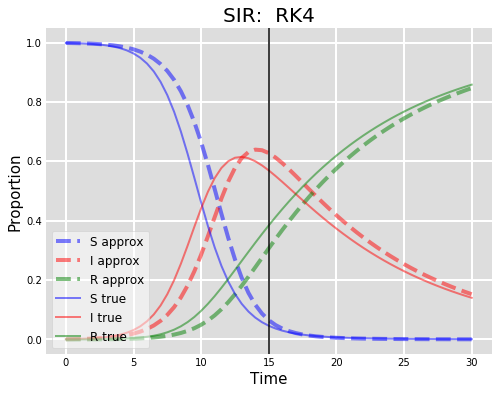

In [54]:
#best_model_ode = Neural_ODE(solver = "Euler").cuda()
x = np.linspace(0, 60//2, 61)
fig=plt.figure(figsize=(8, 6))#fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
y_pred = best_model_ode(t.to(device))
ax.plot(x, y_pred[:,0].cpu().data.numpy(), 'b', alpha=0.5, lw=4, linestyle = "--", label='S approx')
ax.plot(x, y_pred[:,1].cpu().data.numpy(), 'r', alpha=0.5, lw=4, linestyle = "--", label='I approx')
ax.plot(x, y_pred[:,2].cpu().data.numpy(), 'g', alpha=0.5, lw=4, linestyle = "--", label='R approx')

ax.plot(x, y_exact[:,0].cpu().data.numpy(), 'b', alpha=0.5, lw=2,  label='S true')
ax.plot(x, y_exact[:,1].cpu().data.numpy(), 'r', alpha=0.5, lw=2,  label='I true')
ax.plot(x, y_exact[:,2].cpu().data.numpy(), 'g', alpha=0.5, lw=2,  label='R true')
ax.axvline(15, color = "black")
ax.set_xlabel('Time', size = 15)
ax.set_ylabel('Proportion', size = 15)
#ax.set_ylim(-0.1,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(fontsize = 12, loc = 3)
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.title("SIR:  RK4 + Learned " + r"$\beta, \gamma, y_0$", size = 20)#
#plt.savefig("SIR_NeuralODE_RK4.png", dpi = 400 , bbox_inches = "tight")
plt.show()

# SEIR: 
## Fully Connected NN

In [55]:
class FC(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FC, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, 4)
        )
        self.y0 = torch.nn.Parameter(torch.cuda.FloatTensor([[0]]))
    def forward(self, t):
        y_preds = []
        for i in range(len(t)):
            y_preds.append(self.model(t[i].reshape(1,1)))
        return torch.cat(y_preds, dim = 0)

In [56]:
model_fc = FC(input_dim = 1, hidden_dim = 256).cuda()
t = torch.from_numpy(np.linspace(0, 60, 61)).float().cuda()
y_exact = SEIR.float().cuda()/10000
optimizer = torch.optim.Adam(model_fc.parameters(), 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.95)
num_epochs = 3000
loss_fun = torch.nn.MSELoss()
tqdm_epochs = tqdm(range(num_epochs))
min_loss = 10

for e in tqdm_epochs:
    #forward pass
    y_approx = model_fc(t.to(device)[:30])
    loss = loss_fun(y_approx, y_exact[:30].to(device))
    if loss.item() < min_loss:
        best_model_fc = model_fc
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    tqdm_epochs.set_postfix({'loss': torch.sum(loss).item()})

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


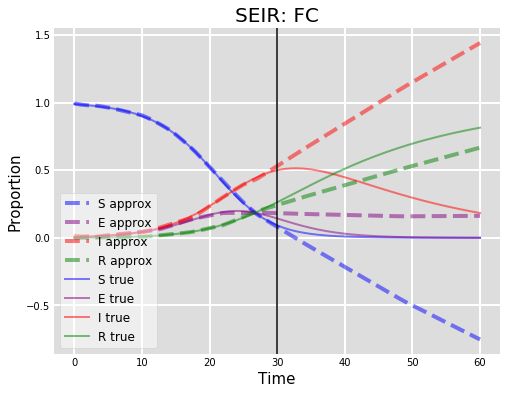

In [59]:
x = np.linspace(0, 60, 61)
fig=plt.figure(figsize=(8, 6))#fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
y_pred = best_model_fc(t.to(device))
ax.plot(x, y_pred[:,0].cpu().data.numpy(), 'b', alpha=0.5, lw=4, linestyle = "--", label='S approx')
ax.plot(x, y_pred[:,1].cpu().data.numpy(), 'purple', alpha=0.5, lw=4, linestyle = "--", label='E approx')
ax.plot(x, y_pred[:,2].cpu().data.numpy(), 'r', alpha=0.5, lw=4, linestyle = "--", label='I approx')
ax.plot(x, y_pred[:,3].cpu().data.numpy(), 'g', alpha=0.5, lw=4, linestyle = "--", label='R approx')

ax.plot(x, y_exact[:,0].cpu().data.numpy(), 'b', alpha=0.5, lw=2,  label='S true')
ax.plot(x, y_exact[:,1].cpu().data.numpy(), 'purple', alpha=0.5, lw=2,  label='E true')
ax.plot(x, y_exact[:,2].cpu().data.numpy(), 'r', alpha=0.5, lw=2,  label='I true')
ax.plot(x, y_exact[:,3].cpu().data.numpy(), 'g', alpha=0.5, lw=2,  label='R true')

ax.axvline(30, color = "black")
ax.set_xlabel('Time', size = 15)
ax.set_ylabel('Proportion', size = 15)
#ax.set_ylim(-0.1,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(fontsize = 12, loc = 3)
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.title("SEIR: FC", fontsize = 20)
#plt.savefig("SEIR_FC.png", dpi = 400 , bbox_inches = "tight")    
plt.show()

In [58]:
print("first 30 steps:", np.round(torch.sqrt(torch.mean(((y_exact - y_pred)**2)[:30])).cpu().data.numpy(), 3))
print("last 30 steps:", np.round(torch.sqrt(torch.mean(((y_exact - y_pred)**2)[30:])).cpu().data.numpy(), 3))

first 30 steps: 0.005
last 30 steps: 0.438


# SEIR: 
## Learn $\beta, \gamma, y_0$ + ODE solver
\begin{align*}
&\frac{dS}{dt} = -\frac{\beta SI}{N} \\
&\frac{dE}{dt} = \frac{\beta SI}{N} - \sigma E \\
&\frac{dI}{dt} = \sigma E - \gamma I \\
&\frac{dR}{dt} = \gamma I \\
& N = I + R + S + E
\end{align*}

In [60]:
# N = 10000, I0 = 100, R0 = 0, E0 = 0, beta = 0.9, gamma = 0.1, sigma = 0.5, num_steps = 60, step_size = 0.5

In [ ]:
#N = 10000, I0 = 10, R0 = 0, E0 = 0, beta = 0.8, gamma = 0.1, sigma = 0.2, num_steps = 60, step size = 1

In [95]:
class Neural_ODE_SEIR(nn.Module):
    def __init__(self, solver = "Euler"):
        super(Neural_ODE_SEIR, self).__init__()
        self.initial = torch.tensor([0.99, 0., 0.01, 0.]).cuda()#torch.nn.Parameter(torch.rand(4)/10)#10000.0)#
        self.beta = torch.tensor(0.9).cuda()#torch.nn.Parameter(torch.rand(1)/10)#
        self.gamma = torch.tensor(0.1).cuda()#torch.nn.Parameter(torch.rand(1)/10)#
        self.sigma = torch.tensor(0.5).cuda()#torch.nn.Parameter(torch.rand(1)/10)#
        self.step = torch.tensor(0.5)
        self.solver = solver
        
    def Euler(self, t):
        S_pred = [self.initial[0].reshape(-1,1)]
        E_pred = [self.initial[1].reshape(-1,1)]
        I_pred = [self.initial[2].reshape(-1,1)]
        R_pred = [self.initial[3].reshape(-1,1)]
        for n in range(len(t)-1):
            S_pred.append((S_pred[n] - self.beta*S_pred[n]*I_pred[n]*self.step).reshape(-1,1))
            E_pred.append((E_pred[n] + (self.beta*S_pred[n]*I_pred[n] - self.sigma*E_pred[n])*self.step).reshape(-1,1))
            I_pred.append((I_pred[n] + (self.sigma*E_pred[n] - self.gamma*I_pred[n])*self.step).reshape(-1,1))
            R_pred.append((R_pred[n] + self.gamma*I_pred[n]*self.step).reshape(-1,1))
        y_pred = torch.cat([torch.cat(S_pred, dim = 0),
                            torch.cat(E_pred, dim = 0),
                            torch.cat(I_pred, dim = 0), 
                            torch.cat(R_pred, dim = 0)], dim = 1)
        return y_pred
    
    def RK4(self, t):
        S_pred = [self.initial[0].reshape(-1,1)]
        E_pred = [self.initial[1].reshape(-1,1)]
        I_pred = [self.initial[2].reshape(-1,1)]
        R_pred = [self.initial[3].reshape(-1,1)]
        
        for n in range(len(t)-1):
            k1 = self.beta*S_pred[n]*I_pred[n]*self.step #dt * f(t[n], y[n]) 
            k2 = (self.beta*(S_pred[n]+ k1/2)*I_pred[n])*self.step #dt * f(t[n] + dt/2, y[n] + k1/2)
            k3 = (self.beta*(S_pred[n]+ k2/2)*I_pred[n])*self.step #dt * f(t[n] + dt/2, y[n] + k2/2)
            k4 = (self.beta*(S_pred[n]+ k3)*I_pred[n])*self.step #dt * f(t[n] + dt, y[n] + k3)            
            S_pred.append((S_pred[n] - 1/6 * (k1 + 2*k2 + 2*k3 + k4)).reshape(-1,1))
            
            k1 = (self.beta*S_pred[n]*I_pred[n] - self.sigma*E_pred[n])*self.step #dt * f(t[n], y[n]) 
            k2 = (self.beta*S_pred[n]*I_pred[n] - self.sigma*(E_pred[n] +  k1/2))*self.step #dt * f(t[n] + dt/2, y[n] + k1/2)
            k3 = (self.beta*S_pred[n]*I_pred[n] - self.sigma*(E_pred[n] +  k2/2))*self.step #dt * f(t[n] + dt/2, y[n] + k2/2)
            k4 = (self.beta*S_pred[n]*I_pred[n] - self.sigma*(E_pred[n] +  k3))*self.step #dt * f(t[n] + dt, y[n] + k3)            
            E_pred.append((E_pred[n] + 1/6 * (k1 + 2*k2 + 2*k3 + k4)).reshape(-1,1))
            
            k1 = (self.sigma*E_pred[n] - self.gamma*I_pred[n])*self.step #dt * f(t[n], y[n]) 
            k2 = (self.sigma*E_pred[n] - self.gamma*(I_pred[n] + k1/2))*self.step #dt * f(t[n] + dt/2, y[n] + k1/2)
            k3 = (self.sigma*E_pred[n] - self.gamma*(I_pred[n] + k2/2))*self.step #dt * f(t[n] + dt/2, y[n] + k2/2)
            k4 = (self.sigma*E_pred[n] - self.gamma*(I_pred[n] + k3))*self.step #dt * f(t[n] + dt, y[n] + k3)   
            I_pred.append((I_pred[n] + 1/6 * (k1 + 2*k2 + 2*k3 + k4)).reshape(-1,1))
            
            R_pred.append((R_pred[n] + self.gamma*I_pred[n]*self.step).reshape(-1,1))

        y_pred = torch.cat([torch.cat(S_pred, dim = 0), 
                            torch.cat(E_pred, dim = 0),
                            torch.cat(I_pred, dim = 0), 
                            torch.cat(R_pred, dim = 0)], dim = 1)
        return y_pred
            
            
    def forward(self, t):
        if self.solver == "Euler":
            return self.Euler(t)
        elif self.solver == "RK4":
            return self.RK4(t)
        else:
            print("Error")        

In [67]:
time = torch.tensor(np.linspace(0, 60//2, 61), requires_grad=True).float().cuda()
model_ode = Neural_ODE_SEIR(solver = "Euler").cuda()
y_exact = SEIR.float().cuda()/10000

optimizer = torch.optim.Adam(model_ode.parameters(), 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.9)
num_epochs = 2000
loss_fun = torch.nn.MSELoss()
tqdm_epochs = tqdm(range(num_epochs))
min_loss = 10

for e in tqdm_epochs:
    y_approx = model_ode(time[:30])
    loss = loss_fun(y_approx, y_exact[:30])
    if loss.item() < min_loss:
        best_model_ode = model_ode
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    tqdm_epochs.set_postfix({'loss': torch.sum(loss).item()})

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [96]:
best_model_ode = Neural_ODE_SEIR(solver = "RK4").cuda()

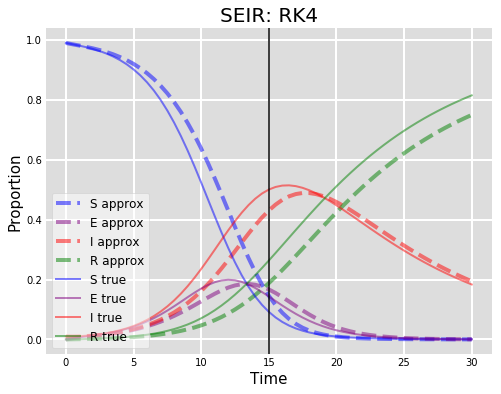

In [98]:
x = np.linspace(0, 60//2, 61)
fig=plt.figure(figsize=(8, 6))#fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
y_pred = best_model_ode(time.to(device))
ax.plot(x, y_pred[:,0].cpu().data.numpy(), 'b', alpha=0.5, lw=4, linestyle = "--", label='S approx')
ax.plot(x, y_pred[:,1].cpu().data.numpy(), 'purple', alpha=0.5, lw=4, linestyle = "--", label='E approx')
ax.plot(x, y_pred[:,2].cpu().data.numpy(), 'r', alpha=0.5, lw=4, linestyle = "--", label='I approx')
ax.plot(x, y_pred[:,3].cpu().data.numpy(), 'g', alpha=0.5, lw=4, linestyle = "--", label='R approx')

ax.plot(x, y_exact[:,0].cpu().data.numpy(), 'b', alpha=0.5, lw=2,  label='S true')
ax.plot(x, y_exact[:,1].cpu().data.numpy(), 'purple', alpha=0.5, lw=2,  label='E true')
ax.plot(x, y_exact[:,2].cpu().data.numpy(), 'r', alpha=0.5, lw=2,  label='I true')
ax.plot(x, y_exact[:,3].cpu().data.numpy(), 'g', alpha=0.5, lw=2,  label='R true')

ax.axvline(15, color = "black")
ax.set_xlabel('Time', size = 15)
ax.set_ylabel('Proportion', size = 15)
#ax.set_ylim(-0.1,1.2)

ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(fontsize = 12, loc = 3)
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.title("SEIR: RK4", size = 20)# + Learned " + r"$\beta, \gamma, y_0$
#plt.savefig("SEIR_RK4.png", dpi = 400 , bbox_inches = "tight")
plt.show()

In [99]:
print("first 30 steps:", np.round(torch.sqrt(torch.mean(((y_exact - y_pred)**2)[:30])).cpu().data.numpy(), 3))
print("last 30 steps:", np.round(torch.sqrt(torch.mean(((y_exact - y_pred)**2)[30:])).cpu().data.numpy(), 3))

first 30 steps: 0.05
last 30 steps: 0.042
